In [1]:
#! !(which python)
# coding: utf-8
###########################
# Author: Yuya Aoki
# Python による Fast SLAM の実装
###########################
%matplotlib inline

In [2]:
import numpy as np
from copy import deepcopy
import math
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


class Landmark(object):
    def __init__(self, x, y):
        self.pos = np.array([x, y])
        self.x = x
        self.y = y

    def draw(self):
        plt.scatter(self.x, self.y, s=300, marker="*",
                    label="landmarks", color="orange")

    def relative_pos(self, pose):
        x, y, theta = pose
        distance = math.sqrt((x - self.x)**2 + (y - self.y)**2)
        direction = math.atan2(self.y - y, self.x - x) - theta
        return distance, direction, self.x, self.y


class Map(object):
    def __init__(self):
        self.landmarks = []

    def append_landmark(self, x, y):
        self.landmarks.append(Landmark(x, y))

    def draw(self):
        for l in self.landmarks:
            l.draw()

    def relative_landmark_positions(self, pose):
        positions = []
        for i, ln in enumerate(self.landmarks):
            distance, direction, x, y = ln.relative_pos(pose)
            positions.append([distance, direction, x, y, i])
        return positions


class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([[0.0], [0.0]])
        self.cov = np.array([[1000000000.0**2, 0.0],
                             [0.0, 1000000000.0**2]])


class Robot(object):
    def __init__(self, pose):
        self.pose = pose

    def draw(self, color=None):
        if color is None:
            color = 'red'
        x, y, theta = self.pose
        plt.quiver(x, y, math.cos(theta), math.sin(theta),
                   color=color, label="actual robot motion")

    def observation(self, m):
        measurements = m.relative_landmark_positions(self.pose)
        observations = []

        for m in measurements:
            distance, direction, lx, ly, i = m
            # 方向の制限（cosの値が正）
            if (math.cos(direction) < 0.0):
                continue

            measured_distance = random.gauss(distance, distance * 0.1)
            measured_direction = random.gauss(direction, 5.0 / 180.0 * math.pi)
            observations.append(
                [measured_distance, measured_direction, lx, ly, i])

        return observations

    def motion_model(self, pos, fw, rot):
        actual_fw = random.gauss(fw, fw / 10)  # 標準偏差にしてfwの10%だけ移動距離に雑音を入れる
        # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg]
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)

        px, py, pt = pos

        # 前進させる
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)

        # 回転。回転角にもrotの10%だけ雑音を入れる
        t = pt + dir_error + random.gauss(rot, rot / 10)

        return np.array([x, y, t])


class Particle():
    def __init__(self, pose, w, m):
        self.w = w
        self.pose = pose
        self.map = [LandmarkEstimation() for i in range(len(m.landmarks))]
        self.m = m

    def motion_update(self, fw, rot, robot):
        self.pose = robot.motion_model(self.pose, fw, rot)

    def measurement_update(self, measurement):
        x, y, theta = self.pose
        distance, direction, lx, ly, i = measurement
        ln = self.map[i]
        lx = distance * math.cos(theta + direction) + x
        ly = distance * math.sin(theta + direction) + y
        # 重みの更新
        delta = np.array([[x], [y]]) - np.array([[lx], [ly]])
        coef = 2 * math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T.dot(np.linalg.inv(ln.cov))).dot(delta)
        self.w *= 1.0 / coef * math.exp(inexp)

        # 地図の書き換え

        z = np.array([[lx], [ly]])

        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[c, -s],
                        [s,  c]])

        err_robot = np.array([[(distance * 0.1)**2, 0.0],
                              [0.0, (distance * math.sin(5.0 / 180.0 * math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)

        ln.cov = np.linalg.inv(np.linalg.inv(ln.cov) +
                               np.linalg.inv(err_world))
        K = (ln.cov).dot(np.linalg.inv(err_world))
        ln.pos += K.dot(z - ln.pos)

    def draw(self, i):
        fig = plt.figure(i, figsize=(4, 4))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0, 1.0)
        sp.set_ylim(-0.5, 1.5)

        self.m.draw()
        x, y, theta = self.pose
        plt.quiver(x, y, math.cos(theta), math.sin(theta),
                   color="red", label="actual robot motion")

        for e in self.map:
            eig_vals, eig_vec = np.linalg.eig(e.cov)
            v1 = eig_vals[0] * eig_vec[:, 0]
            v2 = eig_vals[1] * eig_vec[:, 1]
            v1_direction = math.atan2(v1[1], v1[0])

            x, y = e.pos
            elli = Ellipse([x, y], width=3 * math.sqrt(np.linalg.norm(v1)), height=3 *
                           math.sqrt(np.linalg.norm(v2)), angle=v1_direction / 3.14 * 180)
            elli.set_alpha(0.5)

            sp.add_artist(elli)


class FastSLAM():
    def __init__(self, pose, m):
        self.particles = [Particle(pose, 1.0 / 100, m) for i in range(100)]
        self.m = m

    def draw(self):
        for (i, p) in enumerate(self.particles):
            p.draw(i)
            if i > 3:
                break  # たくさんあるパーティクルを全部描画すると大変なので5個
                # i = 0, 1, 2, 3, 4 <- このとき始めて条件を満たす

    def motion_update(self, fw, rot, robot):
        for p in self.particles:
            p.motion_update(fw, rot, robot)

    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)

        self.resampling()

    def resampling(self):
        num = len(self.particles)                # numはパーティクルの個数
        ws = [e.w for e in self.particles]    # 重みのリストを作る

        if sum(ws) < 1e-100:  # 重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
            ws = [e + 1e-100 for e in ws]

        # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ
        ps = random.choices(self.particles, weights=ws, k=num)
        self.particles = [deepcopy(e) for e in ps]


def set_landmark():
    m = Map()
    m.append_landmark(-0.5, 0.0)
    m.append_landmark(0.5, 0.0)
    m.append_landmark(0.0, 0.5)
    return m


def set_robot(pose=None):
    if pose is None:
        pose = np.array([0.1, 0.2, math.pi * 20.0 / 180])
    robot = Robot(pose)
    return robot


# デバグ用に関数を作っておく
def observation_check(robot, m):
    observations = robot.observation(m)
    # print(observations)

    fig = plt.figure(0, figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0, 1.0)
    sp.set_ylim(-0.5, 1.5)

    for observation in observations:
        x, y, theta = robot.pose
        distance, direction, lx, ly, i = observation
        lx = distance * math.cos(theta + direction) + x
        ly = distance * math.sin(theta + direction) + y
        plt.plot([robot.pose[0],  lx], [robot.pose[1],  ly], color="pink")

        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[c, -s],
                        [s,  c]])

        err_robot = np.array([[(distance * 0.1)**2, 0.0],
                              [0.0, (distance * math.sin(5.0 / 180.0 * math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)

        eig_vals, eig_vec = np.linalg.eig(err_world)
        v1 = eig_vals[0] * eig_vec[:, 0]
        v2 = eig_vals[1] * eig_vec[:, 1]
        v1_direction = math.atan2(v1[1], v1[0])

        elli = Ellipse([lx, ly], width=3 * math.sqrt(np.linalg.norm(v1)), height=3 *
                       math.sqrt(np.linalg.norm(v2)), angle=v1_direction / 3.14 * 180)
        elli.set_alpha(0.2)
        sp.add_artist(elli)

    robot.draw(color='black')
    m.draw()


def one_step(m, slam, robot):
    slam.motion_update(0.2, math.pi / 180.0 * 20, robot)
    robot.pose = robot.motion_model(robot.pose, 0.2, math.pi / 180.0 * 20)
    measurements = robot.observation(m)
    for m in measurements:
        slam.measurement_update(m)


def main():
    m = set_landmark()
    inital_pose = [0.0, 0.0, 0.0]
    robot = set_robot(inital_pose)
    # observation_check(robot, m)
    slam = FastSLAM(robot.pose, m)
    for i in range(50):
        one_step(m, slam, robot)
    slam.draw()
    


if __name__ == '__main__':
    # code
    # main()
    pass


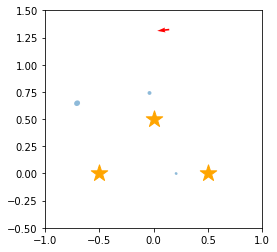

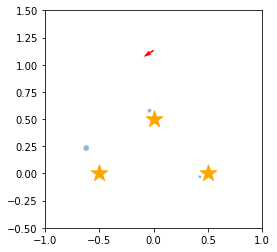

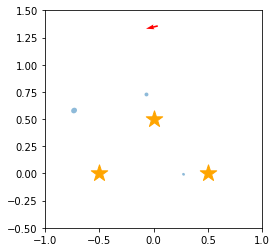

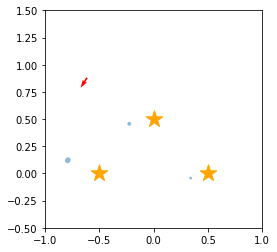

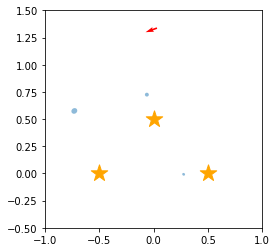

In [3]:
m = set_landmark()
inital_pose = [0.0, 0.0, 0.0]
robot = set_robot(inital_pose)
slam = FastSLAM(robot.pose, m)
for i in range(30):
    one_step(m, slam, robot)
slam.draw()
